# Part 1: Transformers

## Task 1

I am using the Facebook BART model that uses Natural Language Processing for text summarization of news articles. The dataset I will be using this on is News from XSum, CNN/Daily Mail, and Multi-News from Kaggle.

Sources:

https://huggingface.co/docs/transformers/en/model_doc/bart

https://www.kaggle.com/datasets/sbhatti/news-summarization

https://github.com/facebookresearch/fairseq/tree/main/examples/bart

https://huggingface.co/docs/transformers/en/main_classes/trainer

In [9]:
!pip install kagglehub[pandas-datasets]

In [32]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from transformers import BartTokenizer
from tabulate import tabulate
import random
import nltk
from transformers import BartForConditionalGeneration, BartTokenizer

### Data

In [11]:
file_path = "data.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sbhatti/news-summarization",
  file_path,
)

df.sample(5)

<ipython-input-11-089835efe057>:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,Unnamed: 0,ID,Content,Summary,Dataset
387111,387111,32680981,"Sgt Emile Cilliers, 35, from South Africa, was...",A man held on suspicion of attempted murder af...,XSum
775389,775389,32946022,Children at Ampertaine Primary School in Upper...,A Northern Ireland school that adopted Aston V...,XSum
371104,371104,6310ce2cb207bfd7be7f1e91368d86d88c883d97,By . Meghan Keneally . Every one of the former...,All eleven women who have ever hosted on The V...,CNN/Daily Mail
393150,393150,d7a7ec47d0d308280dca3fb1c705849162fc5e8c,By . Mike Dickson . Follow @@Mike_Dickson_DM ....,Murray reveals he was unhappy at Alex Salmond ...,CNN/Daily Mail
356082,356082,8a660dc84ee0edc53d8efe9d507b652318bdcfb1,(CNN) -- Nazi war crimes suspect John Demjanj...,Attorney general's representatives said court ...,CNN/Daily Mail


In [11]:
print(df.shape)

(870521, 5)


In [25]:
print(df.Dataset.unique())

['CNN/Daily Mail' 'Multi-News' 'XSum']


In [37]:
df.Content[0]

"New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks . Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out' A drone which was flown over a packed football stadium in Manchester, England, just over a week ago, resulting in the suspected pilot being arrested . They are consulting with the military and member

In [38]:
df.Summary[0]

'Police have investigated criminals who have rigged guns to drones .\nAnd are working with the military to develop technology to stop attacks .\nIncidents involving drones have drastically increased in New York City .\nLast year a drone was landed in front of German Chancellor Angela Merkel .'

### Pre-Processing

In [82]:
df.isna().sum()

,0
Unnamed: 0,0
ID,56216
Content,34
Summary,0
Dataset,0


In [12]:
clean_df = df.drop(columns=["Unnamed: 0", "ID", "Dataset"])
clean_df = clean_df.dropna()
print(clean_df.shape)
clean_df = clean_df.sample(5000) #clean_df.sample(10000)
print(clean_df.shape)

(870487, 2)
(5000, 2)


In [13]:
# Define input and output columns
input_col = "Content"
output_col = "Summary"

# Split 90/10
train_df, test_df = train_test_split(clean_df, test_size=0.1, random_state=42)

In [14]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [15]:
def tokenize_function(examples):
    return tokenizer(
        examples[input_col].to_list(),
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ), tokenizer(
        examples[output_col].to_list(),
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

train_encodings, train_labels = tokenize_function(train_df)
test_encodings, test_labels = tokenize_function(test_df)

class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels["input_ids"][idx])
        return item

train_dataset = SummarizationDataset(train_encodings, train_labels)
test_dataset = SummarizationDataset(test_encodings, test_labels)


### Model

In [16]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [17]:
model.config

BartConfig {
  "_attn_implementation_autoset": true,
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, DataCollatorForSeq2Seq

In [21]:
training_args = TrainingArguments(
    output_dir="./bart_summarization",
    fp16=True,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=2,
    metric_for_best_model="eval_loss",
)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

<ipython-input-21-d83cf100c441>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

<ipython-input-15-ece610901751>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-ece610901751>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels["input_ids"][idx])
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], d

Step,Training Loss
500,2.172600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
<ipython-input-15-ece610901751>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-ece610901751>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels["input_ids

TrainOutput(global_step=563, training_loss=2.1186185060978784, metrics={'train_runtime': 750.5002, 'train_samples_per_second': 5.996, 'train_steps_per_second': 0.75, 'total_flos': 2437992677376000.0, 'train_loss': 2.1186185060978784, 'epoch': 1.0})

In [14]:
trainer.evaluate()

<ipython-input-7-ece610901751>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-ece610901751>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels["input_ids"][idx])


{'eval_loss': 1.5837899446487427,
 'eval_runtime': 6.2547,
 'eval_samples_per_second': 79.94,
 'eval_steps_per_second': 10.072,
 'epoch': 1.0}

### Generation Example

In [39]:
# og text
sample_text = test_df.iloc[0]["Content"]
sample_text

'The money will cover a visit for at least two Year 10 pupils and a teacher from each post-primary school in Northern Ireland.\nThe Department of Education and Department for Communities are jointly funding "the battlefields project."\nEducation Minister Peter Weir said the scheme would help young people learn more about "the realities of war."\nThe project is now open for schools to express an interest in, with the first trips to take place in June 2017.\nMr Weir said that he hoped schools from all sectors would apply to take part.\n"This scheme will be open to children from all backgrounds and is a unique opportunity to learn about our past," he said.\n"Millions of people lost their lives during the First World War and that must never be forgotten."\n"That is why I believe it is so important that our young people should be encouraged to remember those who died."\nPupils will visit battlefields in Belgium and France like the Somme, where thousands of soldiers from Ireland died.\nThe b

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input_ids = tokenizer(
    sample_text,
    return_tensors="pt",
    max_length=512,
    truncation=True
).input_ids.to(model.device)

summary_ids = model.generate(
    input_ids,
    max_length=64,
    num_beams=4,
    length_penalty=2.0,
    early_stopping=True
)

generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(generated_summary)


A scheme to help young people visit battlefields in Northern Ireland is to be funded by the Department of Education and Communities.


In [50]:
model2 = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

input_ids = tokenizer(
    sample_text,
    return_tensors="pt",
    max_length=512,
    truncation=True
).input_ids.to(model2.device)

summary_ids = model2.generate(
    input_ids,
    max_length=64,
    num_beams=4,
    length_penalty=2.0,
    early_stopping=True
)

generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(generated_summary)


New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms.


### BLEU and ROUGE Scores

In [22]:
!pip install nltk

In [23]:
! pip install -r rouge/requirements.txt
! pip install rouge-score

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rouge/requirements.txt'


In [24]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [26]:
model2 = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def average_bleu_rouge(curr_model):
  bleu_scores = []
  rouge_scores = []

  for i in range(10):
    sample_text = test_df.iloc[i]["Content"]

    input_ids = tokenizer(
        sample_text,
        return_tensors="pt",
        max_length=256,
        truncation=True
    ).input_ids.to(curr_model.device)

    summary_ids = curr_model.generate(
        input_ids,
        max_length=64,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    bleu_score = sentence_bleu([test_df.iloc[0]["Summary"]], summary, smoothing_function=SmoothingFunction().method1)
    bleu_scores.append(bleu_score)
    rouge_score = scorer.score(test_df.iloc[0]["Summary"], summary)
    rouge_scores.append(rouge_score)

  bleu_avg = sum(bleu_scores) / len(bleu_scores)

  rouge1_precision, rouge1_recall, rouge1_f1 = 0, 0, 0
  for scores in rouge_scores:
    rouge1_precision += scores['rouge1'].precision
    rouge1_recall += scores['rouge1'].recall
    rouge1_f1 += scores['rouge1'].fmeasure
  rouge_avg = {
    "precision": rouge1_precision / len(rouge_scores),
    "recall": rouge1_recall / len(rouge_scores),
    "f1": rouge1_f1 / len(rouge_scores)
  }

  return bleu_avg, rouge_avg

print("Original Pre-trained BART")
scores = average_bleu_rouge(model2)
print("BLEU: ", scores[0])
print("ROUGE: ", scores[1])
print("Fine-Tuned BART")
scores2 = average_bleu_rouge(model)
print("BLEU: ", scores2[0])
print("ROUGE: ", scores2[1])

Original Pre-trained BART
BLEU:  0.15534461883789588
ROUGE:  {'precision': 0.09543449251401345, 'recall': 0.17777777777777773, 'f1': 0.12403068505389181}
Fine-Tuned BART
BLEU:  0.17034403623456626
ROUGE:  {'precision': 0.1628379594985762, 'recall': 0.16296296296296295, 'f1': 0.15564439359924095}


The results are given by a qualatative comparison between the original generic BART model and the fine-tuned version, as well as calcualated Bilingual Evaluation Understudy (BLEU) and Recall-Oriented Understudy for Gisting Evaluation (ROUGE) scores. Some of the hyperparameters used were train and test batch sizes, which gave me better results at a slightly larger number of 8 as compared to smaller batches like 2 which ran faster, but gave less accuracy. Another hyperparameter was fp16 which uses mized-precision training to get the benefeits of both faster and more accurate calculations.

The fine-tuning improved the text summarization ability of this LLM on this specific news dataset. You can see in the qualatative comparison that the summary is much more consise, while original BART is very wordy. I calculated the average of the BLEU and ROUGE scores across 10 examples. While the original pre-trained BART model has a BLEU score of $0.1553$, the fine-tuned version had a BLEU score of $0.1703$. The ROUGE scores were much higher for precision, slightly higher F1, and actually slightly lower recall.

# Part 2: Reinforcement Learning

## Task 2
The Netflix homepage is a real-world application of Reinforcement Learning (RL) as a Markov Decision Process (MDP). The specific article below, attempts to find the optimal list of recommendations for a user who has a finite amount of time to make the decision of what to play before they abandon the task. This time budget adds an additional constraint to the recommender system.

One way to look at this problem, is as a MDP where the recommender system is the agent and the user interacting with the recommender systems is the enviorment. They define the list of recomendations as having $k$ items, then model the interaction between the user, $k$-items, and their time budget. The user's time budget is estimated based on the historical data of how long they scroll before they abandon the task. Each state includes the user budget left and the items the user has examined so far. Each action is the user evaluating an item from the list with a certain relevance, and the cost of the time it takes the user to evaluate it. So the state space is all of the possible combinations of time budget remaining and and items that have been looked at from the list. The action space is all the possible ways a user can select or not select items from the list. The transition to the next state depends on whether the user selects the item they view or not. The reward is when the user chooses an item from the slate, if the user does not choose an item, another iteration is necessary or the budget runs out and the task is abandoned. The goal is for the user to play an item from the list, and the recommender system is trained with the users feedback to try to maximize this.

As expected, a larger user time budget increases the probability of the user playing a recommended item as it allows for a larger slate size. So the recomender system needs to generate slates with the ideal balance between item's relevance and the time cost of each item. They found that for this problem, the MDP model for RL performs better than previous systems.


**Sources:**

https://netflixtechblog.com/reinforcement-learning-for-budget-constrained-recommendations-6cbc5263a32a

https://github.com/Netflix-Skunkworks/rl_for_budget_constrained_recs

https://research.netflix.com/research-area/recommendations

## Task 3

Reinforcement Learning can be useful in healthcare applications, as medical treatments are often sequential decision making problems. Many health issues are not solved in one step, but are instead a process of treatments that monitor the patient's health throughout the process. By learning the optimal steps to take with the dynamic system as input, RL models are able to pick up on optimal strategies based on more historical data than a human can process.

As a leading cause of death, sepsis is a very dangerous condition where infection-fighting processes turn on the body and organs rather than fighting the infection. Rapid diagnosis and early treatment are vital to patient survival and avoiding severe sepsis and septic shock. Artificial Intelligence researchers have been working on training models on historical patient data and treatment decisions, with the goal of helping doctors select treatments based on a patient's data.

One open-source project that has addressed this problem was published as "An Empirical Study of Representation Learning for Reinforcement Learning in Healthcare". They look at multiple pre-existing architectures and evaluate them with septic patient data from MIMIC-III. The MIMIC-III dataset is a large publicly-available collection of medical records that include diagnoses, procedures, and patient data like vital signs and lab results.

This study experiments with how different deep learning techniques improve RL decision making. There are seven initial architectures, a basic RNN Autoencoder (RNN),  ODE-RNN,a non-recurrent Autoencoder (AE), Decoupled Dynamics Module (DDM), Deep Signature Transforms (DST), Approximate Information State (AIS), and Neural Controlled Differential Equations (CDE). See the diagram below of Mean Squared Error (MSE) values as a comparison between these models (Fig. 1). As it is necessary to simulate the "cause and effect" relationship of a model's treatment plan and a patient's health, they also developed an algorithm with batch reinforcement learning that estimates each action's results. To mitigate the risks of incorrect extrapolation, they constrained the estimates to keep them from falling outside the supported data called Batch Constrained Q-Learning (BCQ). To further test and compare the quality of treatments policy The treatment policies are all trained using BCQ and evaluated with weighted importance sampling (WIS). A graph of the best policies learned based on the reinforcement learning state representations can be seen below (Fig. 2).

Across the different approaches, the Neural CDE was significantly better than the other model architectures. The AIS and RNN were also relatively successful compared to the non-recurrent models. These results make sense as RNNs work very well for RL applications with sequential data. Another interesting finding is that the increased complexity of deep learning is not particularly effective or necessary in this context, although it's possible they could have performed better with a larger dataset. Overall, models like these can be very effective, and reinforcement learning is beneficial for building models that assist medical professionals in selecting treatment policies.

**Sources:**

https://paperswithcode.com/paper/an-empirical-study-of-representation-learning

https://arxiv.org/pdf/2011.11235v1

https://github.com/MLforHealth/rl_representations

https://pubmed.ncbi.nlm.nih.gov/30349085/

https://developer.ibm.com/learningpaths/get-started-automated-ai-for-decision-making-api/what-is-automated-ai-for-decision-making/

https://paperswithcode.com/dataset/mimic-iii



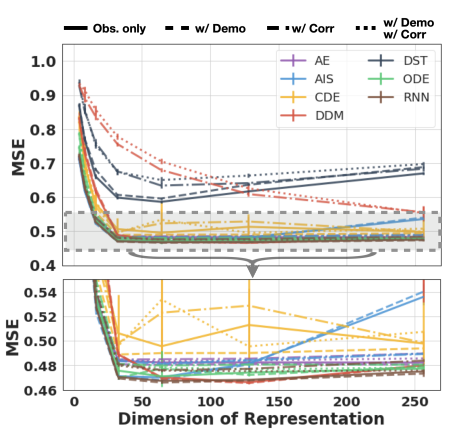

**Fig. 1**

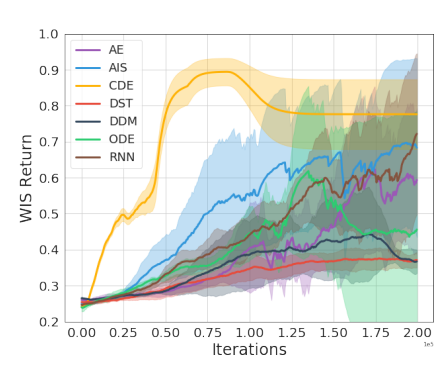

**Fig. 2**

## Task 4

**Sources:**

https://mitpress.mit.edu/9780262039246/reinforcement-learning/

https://github.com/Uzmamushtaque/CSCI-4170-6170/blob/20d362e36ea0c8375656efdb5aba0f58cda0983b/Lecture_17.ipynb#L38

https://huggingface.co/learn/deep-rl-course/en/unit2/q-learning-example

https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial

https://github.com/khpeek/Q-learning-Tic-Tac-Toe

https://github.com/rfeinman/tictactoe-reinforcement-learning

### Game Enviorment

In [33]:
# game of tic tac toe
class TicTacToeGame:
    def __init__(self):
      # make grid and states
        self.board = [0] * 9
        self.end = False
        self.winner = None

    def reset(self):
        self.board = [0] * 9
        self.end = False
        self.winner = None
        return self.board

    def is_winner(self, player):
        winning_combinations = [[0, 1, 2], [3, 4, 5], [6, 7, 8],[0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
        for comb in winning_combinations:
            if all(self.board[i] == player for i in comb):
                return True
        return False

    def is_tie(self):
        return all(x != 0 for x in self.board)

    def available_actions(self):
        return [i for i, x in enumerate(self.board) if x == 0]

    def step(self, action, player):
        if self.board[action] != 0 or self.end:
            return self.board, -1, self.end  # Invalid action

        self.board[action] = player

        # If player wins
        if self.is_winner(player):
            self.end = True
            self.winner = player
            return self.board, 1, self.end
        # if tie
        elif self.is_tie():
            self.end = True
            return self.board, 0, self.end
        # else continue
        else:
            return self.board, 0, self.end

    def print_board(self):
        board = [self.board[i:i+3] for i in range(0, 9, 3)]
        for row in board:
            print(' '.join(['X' if x == 1 else 'O' if x == -1 else '.' for x in row]))

### Q-Learning

In [39]:
# Q-learning
class QLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_state(self, board):
        return tuple(board)

    def choose_action(self, state, available_actions):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(available_actions)
        else:
            # take action with max Q-value
            q_values = [self.q_table.get((state, a), 0) for a in available_actions]
            max_q = max(q_values)
            max_actions = [a for a, q in zip(available_actions, q_values) if q == max_q]
            return random.choice(max_actions)

    def learn(self, state, action, reward, next_state, next_available_actions):
        future_q = 0 if not next_available_actions else max([self.q_table.get((next_state, a), 0) for a in next_available_actions])
        current_q = self.q_table.get((state, action), 0)
        new_q = current_q + self.alpha * (reward + self.gamma * future_q - current_q)
        self.q_table[(state, action)] = new_q

In [35]:
def train(agent, episodes):
    env = TicTacToeGame()
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            available_actions = env.available_actions()
            action = agent.choose_action(agent.get_state(state), available_actions)
            next_state, reward, done = env.step(action, 1)
            # Q plays X
            agent.learn(agent.get_state(state), action, reward, agent.get_state(next_state), env.available_actions())
            state = next_state

            if done:
                break
            # Opponent plays O
            opponent_action = random.choice(env.available_actions())
            next_state, reward, done = env.step(opponent_action, -1)
            state = next_state

In [74]:
# evaluation metric is based on the rate of wins, ties, and losses, incentivising wins
def evaluate(agent, runs):
    env = TicTacToeGame()
    wins, ties, losses = 0, 0, 0
    for r in range(runs):
        state = env.reset()
        done = False
        while not done:
            available_actions = env.available_actions()
            action = agent.choose_action(agent.get_state(state), available_actions)
            #  Q plays X
            next_state, reward, done = env.step(action, 1)
            state = next_state
            if r % 100 == 0:
                print(env.print_board())
            if done:
                if reward == 1:
                    if r % 100 == 0:
                        print("Win!")
                    wins += 1
                elif reward == 0:
                    if r % 100 == 0:
                        print("Tie")
                    ties += 1
                else:
                    losses += 1
                    if r % 100 == 0:
                        print("Loss :(")
                break
            # Opponent plays O
            opponent_action = random.choice(env.available_actions())
            next_state, reward, done = env.step(opponent_action, -1)
            state = next_state
            if r % 100 == 0:
                print(env.print_board())
    return wins / runs, ties / runs, losses / runs

In [76]:
agent = QLearning()
train(agent, episodes=1000)

print("Example Game")
win_rate, tie_rate, loss_rate = evaluate(agent, runs=100)
print("\nWins", win_rate, "%")
print("Ties", tie_rate, "%")
print("Losses", loss_rate, "%")

Example Game
. . .
. . .
. X .
None
. . .
O . .
. X .
None
. . .
O . .
. X X
None
. . .
O . O
. X X
None
X . .
O . O
. X X
None
X . O
O . O
. X X
None
X . O
O . O
X X X
None
Win!

Wins 0.6 %
Ties 0.17 %
Losses 0.0 %


# Part 3: Recommender Systems

In [1]:
! unzip ml-100k.zip -d "movielens100k"

Archive:  ml-100k.zip
   creating: movielens100k/ml-100k/
  inflating: movielens100k/ml-100k/allbut.pl  
  inflating: movielens100k/ml-100k/mku.sh  
  inflating: movielens100k/ml-100k/README  
  inflating: movielens100k/ml-100k/u.data  
  inflating: movielens100k/ml-100k/u.genre  
  inflating: movielens100k/ml-100k/u.info  
  inflating: movielens100k/ml-100k/u.item  
  inflating: movielens100k/ml-100k/u.occupation  
  inflating: movielens100k/ml-100k/u.user  
  inflating: movielens100k/ml-100k/u1.base  
  inflating: movielens100k/ml-100k/u1.test  
  inflating: movielens100k/ml-100k/u2.base  
  inflating: movielens100k/ml-100k/u2.test  
  inflating: movielens100k/ml-100k/u3.base  
  inflating: movielens100k/ml-100k/u3.test  
  inflating: movielens100k/ml-100k/u4.base  
  inflating: movielens100k/ml-100k/u4.test  
  inflating: movielens100k/ml-100k/u5.base  
  inflating: movielens100k/ml-100k/u5.test  
  inflating: movielens100k/ml-100k/ua.base  
  inflating: movielens100k/ml-100k/ua.tes